# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
def RMSE(a,b): 
    return np.sqrt(np.mean((a-b)**2))
from tqdm import tqdm

In [2]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 4000.41 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
init_cat = catalog.analogs
#training data
batch_size = 1000

In [3]:
new_dt = 0.4
keep_ratio = int(new_dt/0.01)
GD.dt_integration = new_dt
catalog.analogs    = init_cat[::keep_ratio,:][:-1]
catalog.successors = init_cat[::keep_ratio,:][1:]
xt.values          = xt.values[::keep_ratio,:]
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

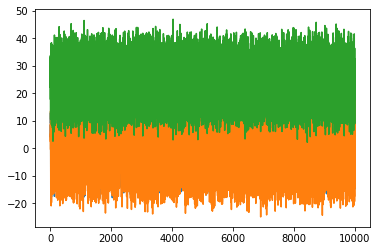

In [4]:
plt.plot(catalog.analogs)

In [5]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))

In [6]:
order=11 #number of stages of the runge kutta scheme

params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[0,2000]
params['lr']=0.001
pretrained = False
path = 'RINN_L63_dt_integration_04_order_11'

# Learn dynamical and integration models, stop when loss ~ 0.2

In [7]:
np.random.seed(0)
torch.manual_seed(0)
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            arg = [GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta]
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
            grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
            grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return grad
model_true  = FC_net_true(params)

class FC_net_true_L96(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true_L96, self).__init__()
        def forward(self, S):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            J = 40
            F = 8
            x = torch.zeros(S.shape[0],J);
            x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
            x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
            x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
            for j in range(2,J-1):
                x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
            dS = x + F;
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return dS
model_true_L96  = FC_net_true_L96(params)

class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true
            self.Dyn_net_True_L96 = model_true_L96
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float(),requires_grad = True)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float(),requires_grad = True)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float(),requires_grad = True)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_True_Model_L96(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True_L96(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True_L96(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1     
        def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True_L96(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True_L96(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True_L96(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True_L96(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1    
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float())
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        def implicit_scheme(self, inp, inpt1, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inpt1))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

In [8]:
x = Variable(torch.from_numpy(X_train).float())
y = Variable(torch.from_numpy(Y_train).float())
z = Variable(torch.from_numpy(Grad_t).float())

# Construct our model by instantiating the class defined above
modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()

if pretrained :
        modelRINN.load_state_dict(torch.load(path+'.pt'))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.001)

In [9]:
clipper = applyRK_Constraints()
clip_value = 1.0
print ('Learning dynamical model')
for t in range(params['ntrain'][1]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            #predi ,grad , inp = modelRINN.implicit_scheme(x[b,:,:],y[b,:,:],params['dt_integration'],order)
            pred1 ,tmp , tmp = modelRINN(x[b,:,:],0.5*params['dt_integration'],order)
            pred1 ,tmp , tmp = modelRINN(pred1,0.5*params['dt_integration'],order)
            #gain_op = modelRINN.opti_gain_lin(h_int, x_lin[0,:1,:],order)
            #loss_opti = customized_loss((gain_op), gain_true)
            # Compute and print loss
            loss_pred1 = criterion(pred, y[b,:,:])
            #loss_pred_i = criterion(predi, y[b,:,:])            
            loss_pred2 = criterion(pred1, y[b,:,:])
            loss = loss_pred1+loss_pred2#+loss_pred_i+loss_pred2# + loss_opti
            if not (np.isnan(loss.data.numpy())) and loss.data.numpy()<10000:
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #for p in modelRINN.parameters():
                #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                #modelRINN.apply(clipper)
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)
            if t>1000:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 0.001
        print(t,loss)
        torch.save(modelRINN.state_dict(), path+'.pt')

Learning dynamical model
0 tensor(622.2607, grad_fn=<AddBackward0>)
1 tensor(516.5223, grad_fn=<AddBackward0>)
2 tensor(454.6516, grad_fn=<AddBackward0>)
3 tensor(414.8286, grad_fn=<AddBackward0>)
4 tensor(386.5737, grad_fn=<AddBackward0>)
5 tensor(364.9046, grad_fn=<AddBackward0>)
6 tensor(347.3449, grad_fn=<AddBackward0>)
7 tensor(332.5952, grad_fn=<AddBackward0>)
8 tensor(319.9459, grad_fn=<AddBackward0>)
9 tensor(309.0072, grad_fn=<AddBackward0>)
10 tensor(299.5598, grad_fn=<AddBackward0>)
11 tensor(291.4613, grad_fn=<AddBackward0>)
12 tensor(284.5885, grad_fn=<AddBackward0>)
13 tensor(278.8080, grad_fn=<AddBackward0>)
14 tensor(273.9710, grad_fn=<AddBackward0>)
15 tensor(269.9229, grad_fn=<AddBackward0>)
16 tensor(266.5166, grad_fn=<AddBackward0>)
17 tensor(263.6215, grad_fn=<AddBackward0>)
18 tensor(261.1264, grad_fn=<AddBackward0>)
19 tensor(258.9380, grad_fn=<AddBackward0>)
20 tensor(256.9792, grad_fn=<AddBackward0>)
21 tensor(255.1873, grad_fn=<AddBackward0>)
22 tensor(253.514

184 tensor(112.5865, grad_fn=<AddBackward0>)
185 tensor(112.1257, grad_fn=<AddBackward0>)
186 tensor(111.5604, grad_fn=<AddBackward0>)
187 tensor(110.9495, grad_fn=<AddBackward0>)
188 tensor(110.4717, grad_fn=<AddBackward0>)
189 tensor(109.9130, grad_fn=<AddBackward0>)
190 tensor(109.2618, grad_fn=<AddBackward0>)
191 tensor(108.5583, grad_fn=<AddBackward0>)
192 tensor(107.8898, grad_fn=<AddBackward0>)
193 tensor(107.1809, grad_fn=<AddBackward0>)
194 tensor(106.4714, grad_fn=<AddBackward0>)
195 tensor(105.5774, grad_fn=<AddBackward0>)
196 tensor(104.8546, grad_fn=<AddBackward0>)
197 tensor(104.2147, grad_fn=<AddBackward0>)
198 tensor(103.7019, grad_fn=<AddBackward0>)
199 tensor(102.2924, grad_fn=<AddBackward0>)
200 tensor(101.4058, grad_fn=<AddBackward0>)
201 tensor(100.3052, grad_fn=<AddBackward0>)
202 tensor(99.1683, grad_fn=<AddBackward0>)
203 tensor(97.9131, grad_fn=<AddBackward0>)
204 tensor(96.8727, grad_fn=<AddBackward0>)
205 tensor(95.7055, grad_fn=<AddBackward0>)
206 tensor(94.

370 tensor(65.8694, grad_fn=<AddBackward0>)
371 tensor(65.7611, grad_fn=<AddBackward0>)
372 tensor(65.6532, grad_fn=<AddBackward0>)
373 tensor(65.5456, grad_fn=<AddBackward0>)
374 tensor(65.4383, grad_fn=<AddBackward0>)
375 tensor(65.3312, grad_fn=<AddBackward0>)
376 tensor(65.2245, grad_fn=<AddBackward0>)
377 tensor(65.1181, grad_fn=<AddBackward0>)
378 tensor(65.0118, grad_fn=<AddBackward0>)
379 tensor(64.9058, grad_fn=<AddBackward0>)
380 tensor(64.8000, grad_fn=<AddBackward0>)
381 tensor(64.6943, grad_fn=<AddBackward0>)
382 tensor(64.5888, grad_fn=<AddBackward0>)
383 tensor(64.4833, grad_fn=<AddBackward0>)
384 tensor(64.3780, grad_fn=<AddBackward0>)
385 tensor(64.2727, grad_fn=<AddBackward0>)
386 tensor(64.1674, grad_fn=<AddBackward0>)
387 tensor(64.0621, grad_fn=<AddBackward0>)
388 tensor(63.9569, grad_fn=<AddBackward0>)
389 tensor(63.8515, grad_fn=<AddBackward0>)
390 tensor(63.7462, grad_fn=<AddBackward0>)
391 tensor(63.6407, grad_fn=<AddBackward0>)
392 tensor(63.5351, grad_fn=<Add

557 tensor(28.0949, grad_fn=<AddBackward0>)
558 tensor(27.6906, grad_fn=<AddBackward0>)
559 tensor(27.2890, grad_fn=<AddBackward0>)
560 tensor(26.8904, grad_fn=<AddBackward0>)
561 tensor(26.4919, grad_fn=<AddBackward0>)
562 tensor(26.0966, grad_fn=<AddBackward0>)
563 tensor(25.7034, grad_fn=<AddBackward0>)
564 tensor(25.3133, grad_fn=<AddBackward0>)
565 tensor(24.9278, grad_fn=<AddBackward0>)
566 tensor(24.5470, grad_fn=<AddBackward0>)
567 tensor(24.1713, grad_fn=<AddBackward0>)
568 tensor(23.8005, grad_fn=<AddBackward0>)
569 tensor(23.4350, grad_fn=<AddBackward0>)
570 tensor(23.0750, grad_fn=<AddBackward0>)
571 tensor(22.7206, grad_fn=<AddBackward0>)
572 tensor(22.3722, grad_fn=<AddBackward0>)
573 tensor(22.0299, grad_fn=<AddBackward0>)
574 tensor(21.6936, grad_fn=<AddBackward0>)
575 tensor(21.3637, grad_fn=<AddBackward0>)
576 tensor(21.0402, grad_fn=<AddBackward0>)
577 tensor(20.7231, grad_fn=<AddBackward0>)
578 tensor(20.4126, grad_fn=<AddBackward0>)
579 tensor(20.1086, grad_fn=<Add

746 tensor(5.2801, grad_fn=<AddBackward0>)
747 tensor(5.2414, grad_fn=<AddBackward0>)
748 tensor(5.2030, grad_fn=<AddBackward0>)
749 tensor(5.1650, grad_fn=<AddBackward0>)
750 tensor(5.1273, grad_fn=<AddBackward0>)
751 tensor(5.0901, grad_fn=<AddBackward0>)
752 tensor(5.0533, grad_fn=<AddBackward0>)
753 tensor(5.0170, grad_fn=<AddBackward0>)
754 tensor(4.9811, grad_fn=<AddBackward0>)
755 tensor(4.9456, grad_fn=<AddBackward0>)
756 tensor(4.9106, grad_fn=<AddBackward0>)
757 tensor(4.8760, grad_fn=<AddBackward0>)
758 tensor(4.8419, grad_fn=<AddBackward0>)
759 tensor(4.8083, grad_fn=<AddBackward0>)
760 tensor(4.7750, grad_fn=<AddBackward0>)
761 tensor(4.7422, grad_fn=<AddBackward0>)
762 tensor(4.7099, grad_fn=<AddBackward0>)
763 tensor(4.6779, grad_fn=<AddBackward0>)
764 tensor(4.6464, grad_fn=<AddBackward0>)
765 tensor(4.6152, grad_fn=<AddBackward0>)
766 tensor(4.5845, grad_fn=<AddBackward0>)
767 tensor(4.5541, grad_fn=<AddBackward0>)
768 tensor(4.5241, grad_fn=<AddBackward0>)
769 tensor(

937 tensor(1.8668, grad_fn=<AddBackward0>)
938 tensor(1.8587, grad_fn=<AddBackward0>)
939 tensor(1.8507, grad_fn=<AddBackward0>)
940 tensor(1.8429, grad_fn=<AddBackward0>)
941 tensor(1.8350, grad_fn=<AddBackward0>)
942 tensor(1.8267, grad_fn=<AddBackward0>)
943 tensor(1.8187, grad_fn=<AddBackward0>)
944 tensor(1.8106, grad_fn=<AddBackward0>)
945 tensor(1.8026, grad_fn=<AddBackward0>)
946 tensor(1.7946, grad_fn=<AddBackward0>)
947 tensor(1.7867, grad_fn=<AddBackward0>)
948 tensor(1.7789, grad_fn=<AddBackward0>)
949 tensor(1.7710, grad_fn=<AddBackward0>)
950 tensor(1.7632, grad_fn=<AddBackward0>)
951 tensor(1.7554, grad_fn=<AddBackward0>)
952 tensor(1.7477, grad_fn=<AddBackward0>)
953 tensor(1.7400, grad_fn=<AddBackward0>)
954 tensor(1.7324, grad_fn=<AddBackward0>)
955 tensor(1.7248, grad_fn=<AddBackward0>)
956 tensor(1.7173, grad_fn=<AddBackward0>)
957 tensor(1.7098, grad_fn=<AddBackward0>)
958 tensor(1.7023, grad_fn=<AddBackward0>)
959 tensor(1.6949, grad_fn=<AddBackward0>)
960 tensor(

1125 tensor(0.8513, grad_fn=<AddBackward0>)
1126 tensor(0.8479, grad_fn=<AddBackward0>)
1127 tensor(0.8446, grad_fn=<AddBackward0>)
1128 tensor(0.8412, grad_fn=<AddBackward0>)
1129 tensor(0.8379, grad_fn=<AddBackward0>)
1130 tensor(0.8346, grad_fn=<AddBackward0>)
1131 tensor(0.8313, grad_fn=<AddBackward0>)
1132 tensor(0.8281, grad_fn=<AddBackward0>)
1133 tensor(0.8248, grad_fn=<AddBackward0>)
1134 tensor(0.8215, grad_fn=<AddBackward0>)
1135 tensor(0.8183, grad_fn=<AddBackward0>)
1136 tensor(0.8151, grad_fn=<AddBackward0>)
1137 tensor(0.8119, grad_fn=<AddBackward0>)
1138 tensor(0.8087, grad_fn=<AddBackward0>)
1139 tensor(0.8055, grad_fn=<AddBackward0>)
1140 tensor(0.8024, grad_fn=<AddBackward0>)
1141 tensor(0.7992, grad_fn=<AddBackward0>)
1142 tensor(0.7961, grad_fn=<AddBackward0>)
1143 tensor(0.7929, grad_fn=<AddBackward0>)
1144 tensor(0.7898, grad_fn=<AddBackward0>)
1145 tensor(0.7867, grad_fn=<AddBackward0>)
1146 tensor(0.7837, grad_fn=<AddBackward0>)
1147 tensor(0.7806, grad_fn=<Add

1312 tensor(0.3659, grad_fn=<AddBackward0>)
1313 tensor(0.3640, grad_fn=<AddBackward0>)
1314 tensor(0.3621, grad_fn=<AddBackward0>)
1315 tensor(0.3602, grad_fn=<AddBackward0>)
1316 tensor(0.3583, grad_fn=<AddBackward0>)
1317 tensor(0.3565, grad_fn=<AddBackward0>)
1318 tensor(0.3546, grad_fn=<AddBackward0>)
1319 tensor(0.3528, grad_fn=<AddBackward0>)
1320 tensor(0.3510, grad_fn=<AddBackward0>)
1321 tensor(0.3493, grad_fn=<AddBackward0>)
1322 tensor(0.3475, grad_fn=<AddBackward0>)
1323 tensor(0.3458, grad_fn=<AddBackward0>)
1324 tensor(0.3441, grad_fn=<AddBackward0>)
1325 tensor(0.3424, grad_fn=<AddBackward0>)
1326 tensor(0.3407, grad_fn=<AddBackward0>)
1327 tensor(0.3390, grad_fn=<AddBackward0>)
1328 tensor(0.3374, grad_fn=<AddBackward0>)
1329 tensor(0.3357, grad_fn=<AddBackward0>)
1330 tensor(0.3341, grad_fn=<AddBackward0>)
1331 tensor(0.3324, grad_fn=<AddBackward0>)
1332 tensor(0.3308, grad_fn=<AddBackward0>)
1333 tensor(0.3292, grad_fn=<AddBackward0>)
1334 tensor(0.3276, grad_fn=<Add

1499 tensor(0.1589, grad_fn=<AddBackward0>)
1500 tensor(0.1583, grad_fn=<AddBackward0>)
1501 tensor(0.1578, grad_fn=<AddBackward0>)
1502 tensor(0.1573, grad_fn=<AddBackward0>)
1503 tensor(0.1568, grad_fn=<AddBackward0>)
1504 tensor(0.1563, grad_fn=<AddBackward0>)
1505 tensor(0.1558, grad_fn=<AddBackward0>)
1506 tensor(0.1554, grad_fn=<AddBackward0>)
1507 tensor(0.1549, grad_fn=<AddBackward0>)
1508 tensor(0.1544, grad_fn=<AddBackward0>)
1509 tensor(0.1540, grad_fn=<AddBackward0>)
1510 tensor(0.1535, grad_fn=<AddBackward0>)
1511 tensor(0.1531, grad_fn=<AddBackward0>)
1512 tensor(0.1526, grad_fn=<AddBackward0>)
1513 tensor(0.1522, grad_fn=<AddBackward0>)
1514 tensor(0.1517, grad_fn=<AddBackward0>)
1515 tensor(0.1513, grad_fn=<AddBackward0>)
1516 tensor(0.1508, grad_fn=<AddBackward0>)
1517 tensor(0.1504, grad_fn=<AddBackward0>)
1518 tensor(0.1499, grad_fn=<AddBackward0>)
1519 tensor(0.1495, grad_fn=<AddBackward0>)
1520 tensor(0.1491, grad_fn=<AddBackward0>)
1521 tensor(0.1486, grad_fn=<Add

1686 tensor(0.0979, grad_fn=<AddBackward0>)
1687 tensor(0.0978, grad_fn=<AddBackward0>)
1688 tensor(0.0977, grad_fn=<AddBackward0>)
1689 tensor(0.0975, grad_fn=<AddBackward0>)
1690 tensor(0.0974, grad_fn=<AddBackward0>)
1691 tensor(0.0973, grad_fn=<AddBackward0>)
1692 tensor(0.0971, grad_fn=<AddBackward0>)
1693 tensor(0.0970, grad_fn=<AddBackward0>)
1694 tensor(0.0969, grad_fn=<AddBackward0>)
1695 tensor(0.0968, grad_fn=<AddBackward0>)
1696 tensor(0.0966, grad_fn=<AddBackward0>)
1697 tensor(0.0965, grad_fn=<AddBackward0>)
1698 tensor(0.0964, grad_fn=<AddBackward0>)
1699 tensor(0.0963, grad_fn=<AddBackward0>)
1700 tensor(0.0961, grad_fn=<AddBackward0>)
1701 tensor(0.0960, grad_fn=<AddBackward0>)
1702 tensor(0.0959, grad_fn=<AddBackward0>)
1703 tensor(0.0958, grad_fn=<AddBackward0>)
1704 tensor(0.0956, grad_fn=<AddBackward0>)
1705 tensor(0.0955, grad_fn=<AddBackward0>)
1706 tensor(0.0954, grad_fn=<AddBackward0>)
1707 tensor(0.0953, grad_fn=<AddBackward0>)
1708 tensor(0.0952, grad_fn=<Add

1873 tensor(0.0783, grad_fn=<AddBackward0>)
1874 tensor(0.0783, grad_fn=<AddBackward0>)
1875 tensor(0.0782, grad_fn=<AddBackward0>)
1876 tensor(0.0781, grad_fn=<AddBackward0>)
1877 tensor(0.0780, grad_fn=<AddBackward0>)
1878 tensor(0.0780, grad_fn=<AddBackward0>)
1879 tensor(0.0779, grad_fn=<AddBackward0>)
1880 tensor(0.0778, grad_fn=<AddBackward0>)
1881 tensor(0.0777, grad_fn=<AddBackward0>)
1882 tensor(0.0777, grad_fn=<AddBackward0>)
1883 tensor(0.0776, grad_fn=<AddBackward0>)
1884 tensor(0.0775, grad_fn=<AddBackward0>)
1885 tensor(0.0774, grad_fn=<AddBackward0>)
1886 tensor(0.0774, grad_fn=<AddBackward0>)
1887 tensor(0.0773, grad_fn=<AddBackward0>)
1888 tensor(0.0772, grad_fn=<AddBackward0>)
1889 tensor(0.0771, grad_fn=<AddBackward0>)
1890 tensor(0.0771, grad_fn=<AddBackward0>)
1891 tensor(0.0770, grad_fn=<AddBackward0>)
1892 tensor(0.0769, grad_fn=<AddBackward0>)
1893 tensor(0.0769, grad_fn=<AddBackward0>)
1894 tensor(0.0768, grad_fn=<AddBackward0>)
1895 tensor(0.0767, grad_fn=<Add

# Short term forecast Perfs 

In [10]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())
y_pred_init[0,:] = xt.values[0,:]
for i in range(1,nb_steps_pred):
    y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())

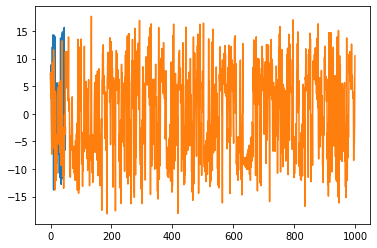

In [11]:
plt.plot(xt.values[:50,0])
plt.plot(y_pred_init[:,0])

In [12]:
print('RMSE t+dt : ',RMSE(xt.values[1,:],y_pred_init[1,:]))
print('RMSE t+4dt : ',RMSE(xt.values[4,:],y_pred_init[4,:]))

RMSE t+dt :  0.18981133903448597
RMSE t+4dt :  1.9321671268177403


Text(0.5, 0, '$z_3$')

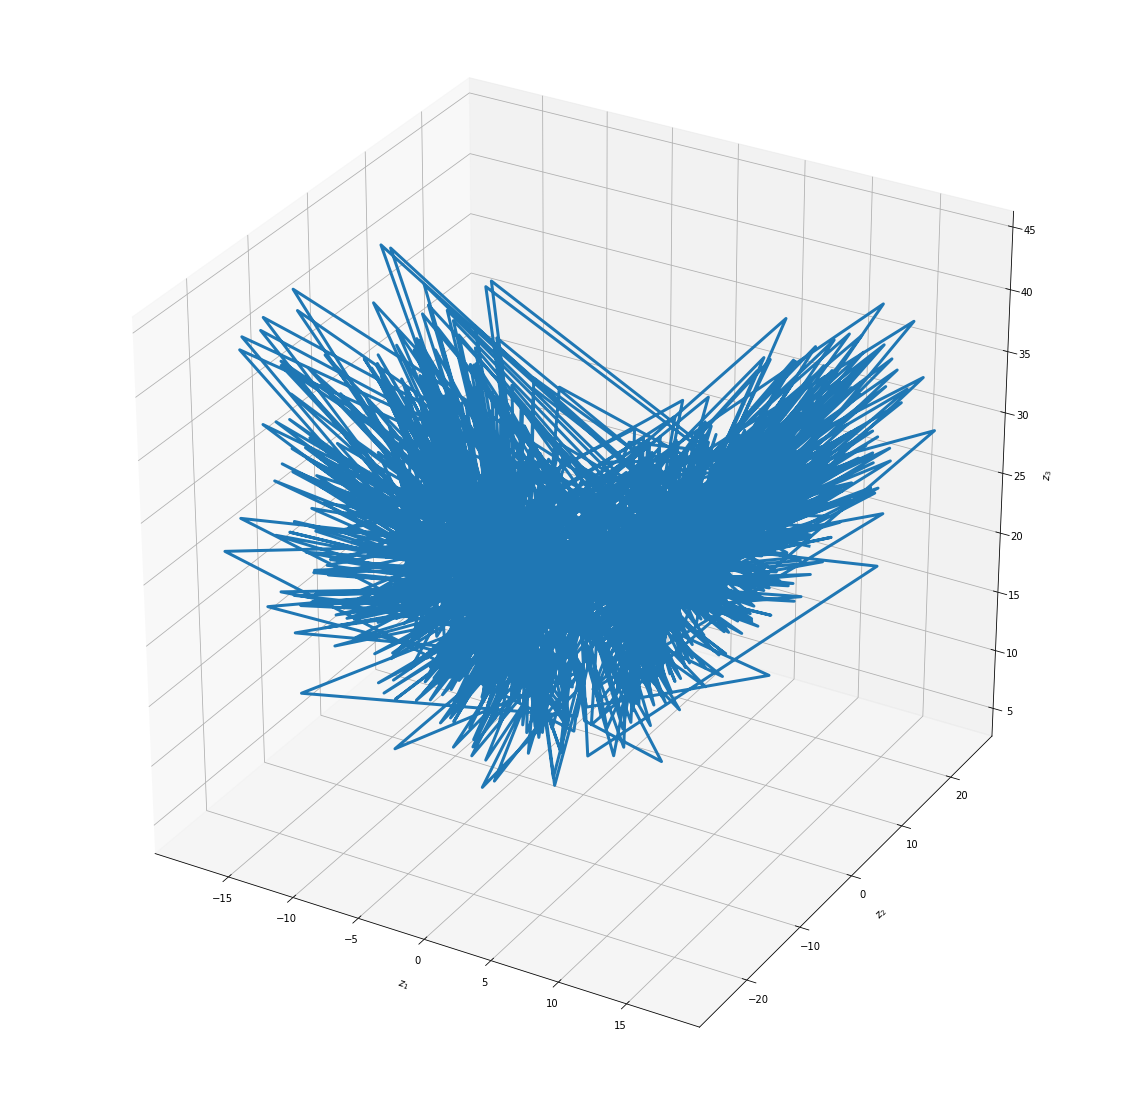

In [13]:
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred_init[:,0],y_pred_init[:,1],y_pred_init[:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)


# Stability perfs (1D)

In [14]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()

import sympy as sp
xt, h = sp.symbols('xt h')

In [15]:
# computing analytic form of the integration scheme
k = [(modelRINN.Dyn_net_lin(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net_lin(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [16]:
# RK4 analytic integration scheme
grad = modelRINN.Dyn_net_lin(xt)
k1   = modelRINN.Dyn_net_lin(xt)
k2   = modelRINN.Dyn_net_lin(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net_lin(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net_lin(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [17]:
# stability graph
hi = np.arange(0,20+0.000001,0.01)
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))
gainE = np.zeros_like(hi)
for i in range(len(hi)):
    gainE[i] = np.abs(1-0.5*hi[i])
gain = np.zeros_like(hi)
for i in range(len(hi)):
    gain[i] = np.abs(g.evalf(subs={h: hi[i]}))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


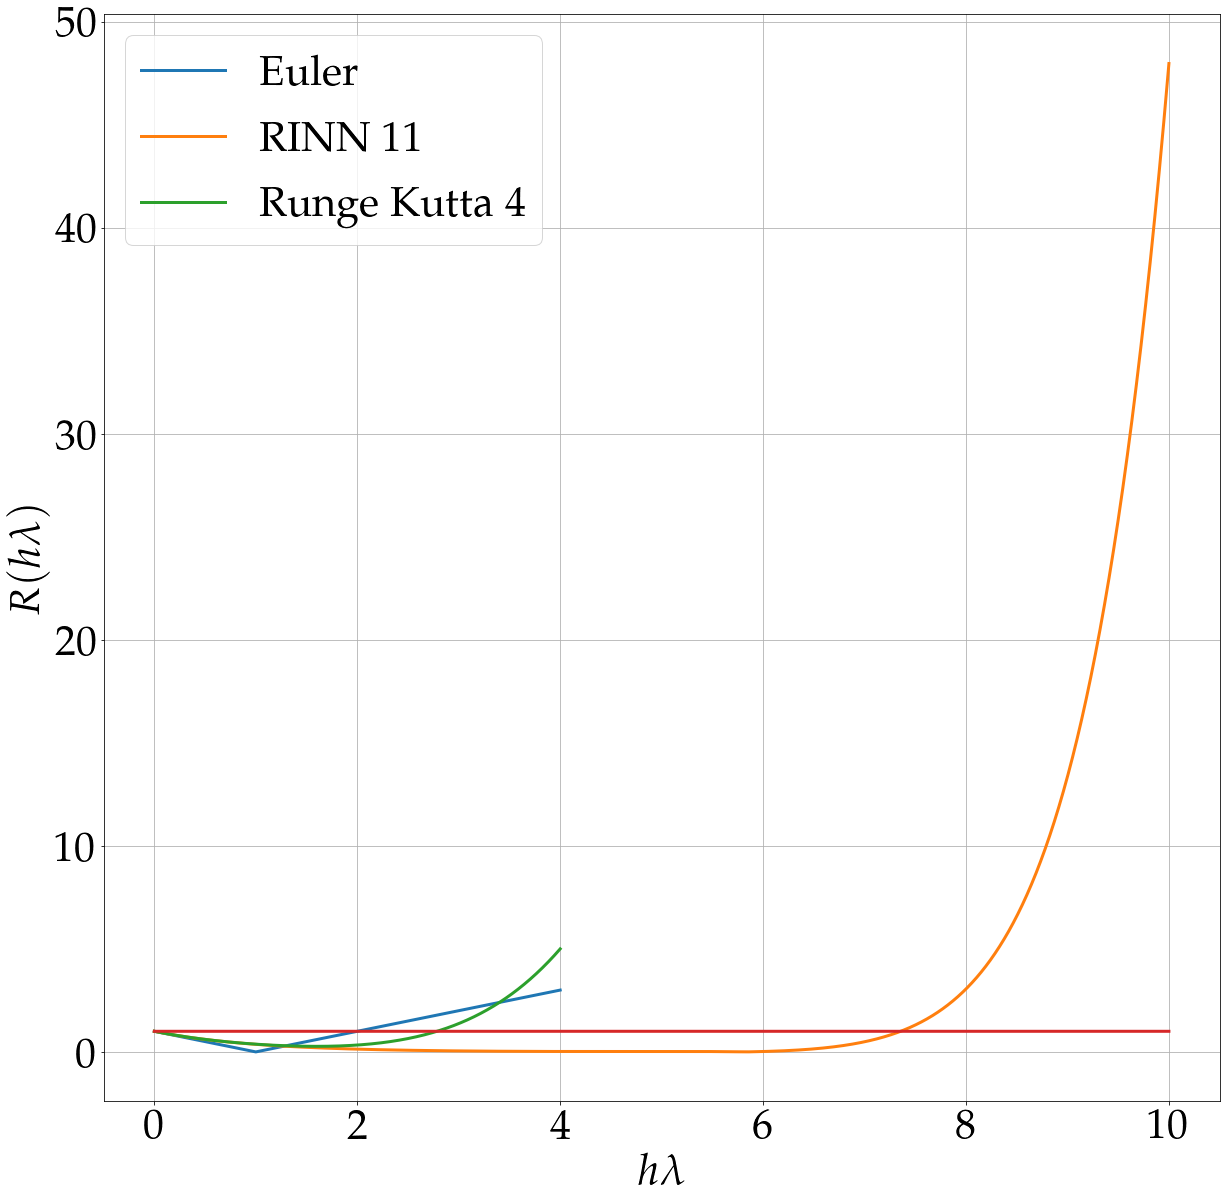

In [18]:
length_h = hi.shape[0]
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:(length_h-1200)]*0.5,gainE[:(length_h-1200)],label = 'Euler',lw = 3)
plt.plot(hi[:length_h]*0.5,gain[:length_h],label = 'RINN 11',lw = 3)
plt.plot(hi[:(length_h-1200)]*0.5,gainRK4[:(length_h-1200)],label = 'Runge Kutta 4',lw = 3)
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]),lw = 3)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()


In [19]:
modelRINN.b.sum() # RK constraint respected :)

tensor(1.0000, grad_fn=<SumBackward0>)

In [20]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h, lam = sp.symbols('xt h \lambda')
k = [lam*xt]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((lam*(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [21]:
g

2.46140153615585e-9*\lambda**11*h**11 + 6.52417271130996e-8*\lambda**10*h**10 + 1.1314915141146e-6*\lambda**9*h**9 + 1.42352993918512e-5*\lambda**8*h**8 + 0.000141166489665649*\lambda**7*h**7 + 0.00113801502002059*\lambda**6*h**6 + 0.00743896646214646*\lambda**5*h**5 + 0.0393599878320066*\lambda**4*h**4 + 0.16304519115557*\lambda**3*h**3 + 0.497144646405289*\lambda**2*h**2 + 0.999999977648258*\lambda*h + 1.0

# 2D stability

In [22]:
# generating training data
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.1+1.0j
        x0 = 0.5+0.5j
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 60.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train_r = np.reshape(catalog.true_solution.real[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
X_train_i = np.reshape(catalog.true_solution.imag[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_r = np.reshape(catalog.true_solution.real[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_i = np.reshape(catalog.true_solution.imag[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

In [23]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()[0,:,:]
b=modelRINN.b.clone().data.numpy()[0,:]
c=modelRINN.c.clone().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

import sympy as sp
x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
x2,im_w    = sp.symbols('x2 im_w',real=True)

xt   = sp.symbols('x1+ix2')
lamb = re_w+sp.I*im_w

In [24]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [25]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [04:44<00:00,  7.04it/s]


In [26]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:08<00:00, 236.15it/s]


In [27]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [01:41<00:00, 19.71it/s]


(-7.0, 7.0)

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


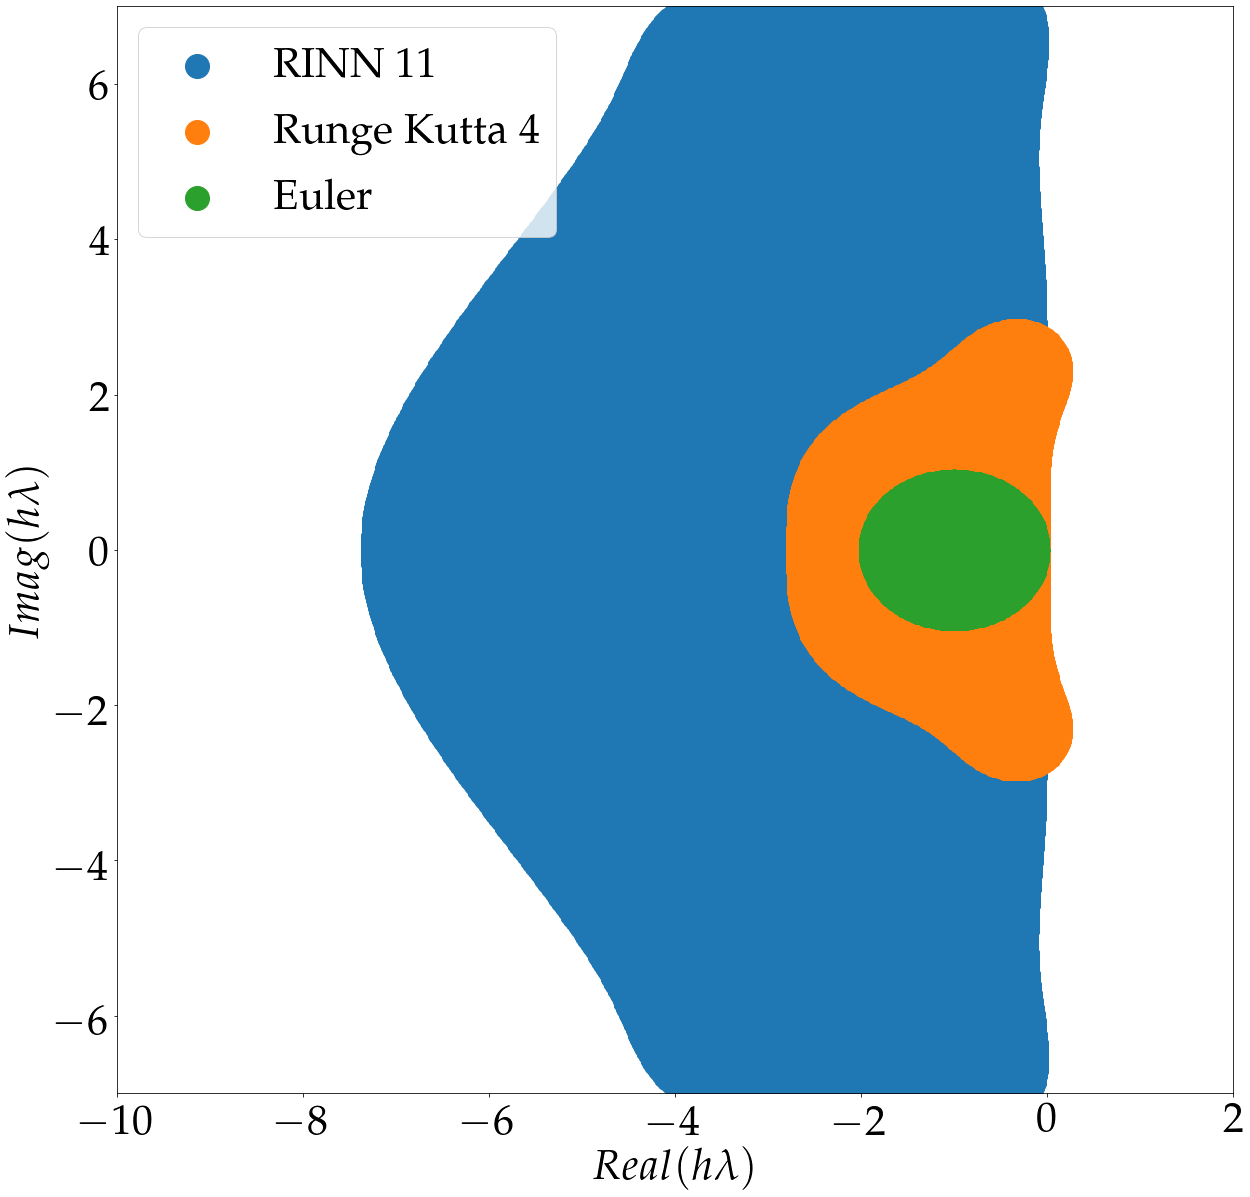

In [28]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))

plt.scatter(np.array(list_x),np.array(list_y), label = 'RINN 11')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4), label = 'Runge Kutta 4')
plt.scatter(np.array(list_xE),np.array(list_yE), label = 'Euler')
plt.legend(markerscale=4.)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-10,2)
plt.ylim(-7,7)

# Generalizability

In [29]:
nb_steps_pred = 10000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(np.ones(3),(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

Text(0.5, 0, '$z_3$')

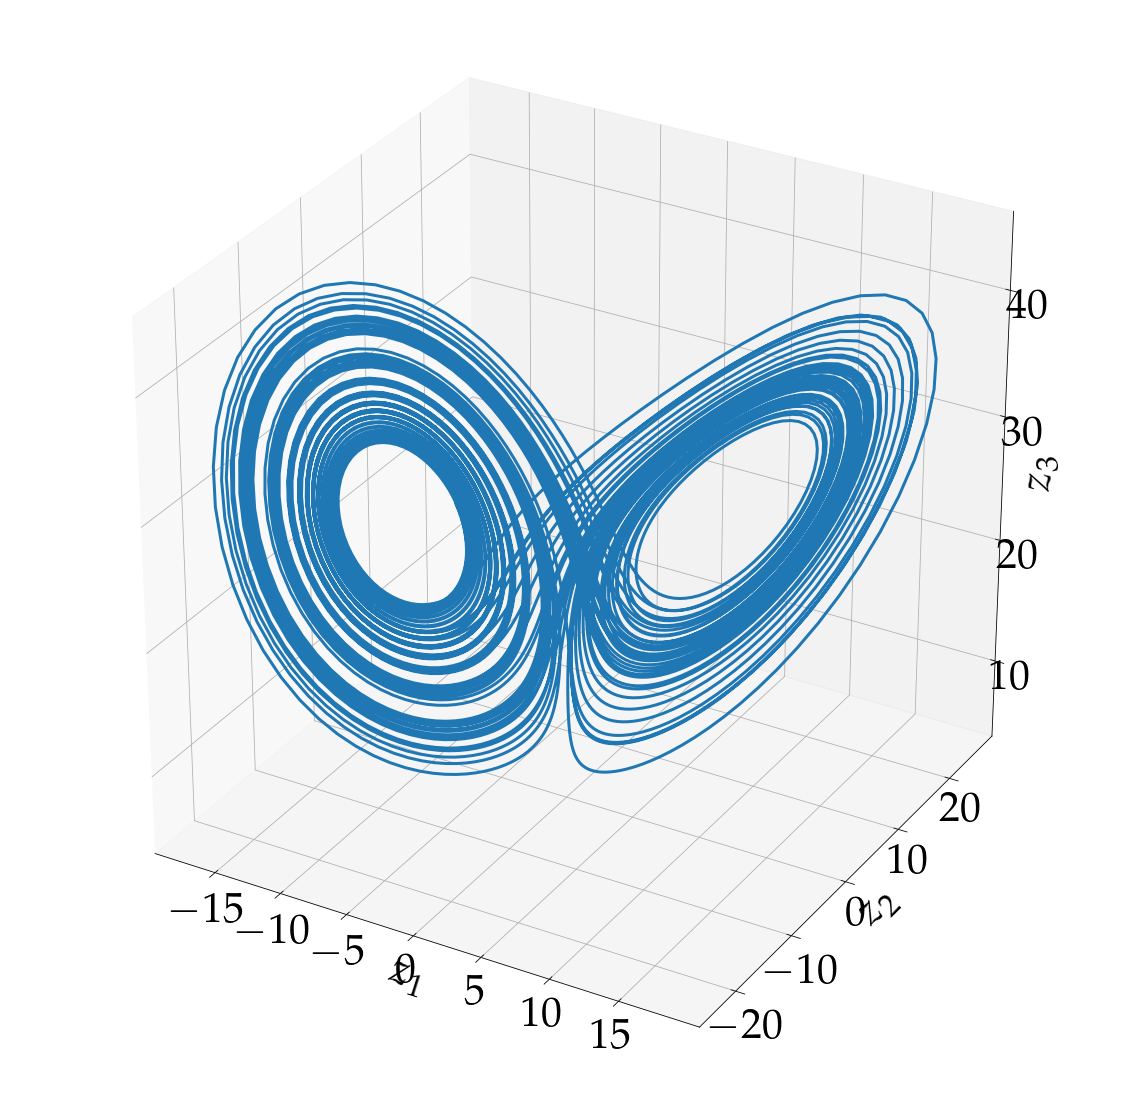

In [30]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred[2000:,0],y_pred[2000:,1],y_pred[2000:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)

In [31]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN.flow_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,40))).float())

<Figure size 360x360 with 0 Axes>

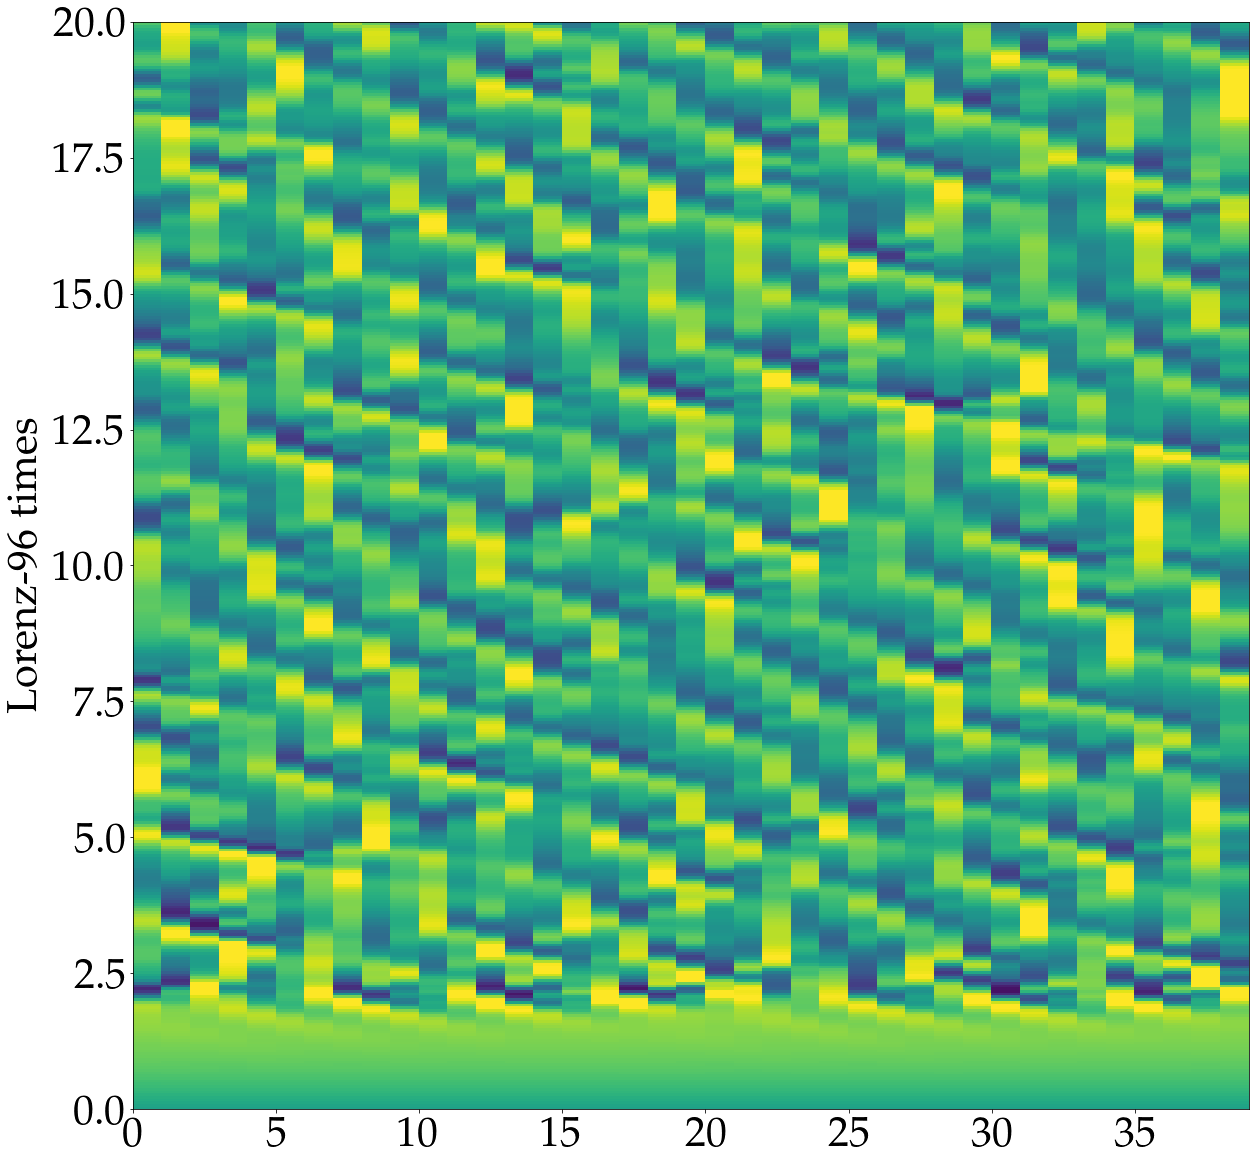

In [32]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,y_pred);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

In [33]:
from tabulate import tabulate

In [34]:
print(tabulate(a, tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
  0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.13282 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
 -0.01533 & 0.19936 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.06830 & 0.03882 & 0.17721 & 0.00000 & 0.00000 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.05088 & 0.04762 & 0.07653 & 0.20184 & 0.00000 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.05444 & 0.09223 & 0.08569 & 0.06398 & 0.19936 & 0.00000 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.10848 & 0.12104 & 0.08825 & 0.09688 & 0.01685 & 0.22079 & 0.00000 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
 -0.00214 & 0.11741 & 0.10766 & 0.07588 & 0.12490 & 0.06258 & 0.17773 & 0.00000 &  0.00000 & 0.00000 & 0.00000 \\
  0.03866 & 0.07149 & 0.12547 & 0.10885 & 0.07602 & 

In [35]:
print(tabulate(b.reshape(1,-1), tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
 0.04237 & 0.10164 & 0.08155 & 0.12025 & 0.09046 & 0.13617 & 0.06988 & 0.11978 & 0.03882 & 0.14815 & 0.05093 \\
\hline
\end{tabular}


In [36]:
print(tabulate(c.reshape(1,-1), tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
 0.00000 & 0.13282 & 0.18403 & 0.28433 & 0.37687 & 0.49570 & 0.65230 & 0.66402 & 0.78754 & 0.85205 & 1.00000 \\
\hline
\end{tabular}
